In [15]:
import warnings
warnings.filterwarnings('ignore')
import stwcs
import glob
import sys
import os
import shutil
import time
import filecmp
import astroquery
import progressbar
import copy
import requests
import random
import astropy.wcs as wcs
import numpy as np
from contextlib import contextmanager
from astropy import units as u
from astropy.utils.data import clear_download_cache,download_file
from astropy.io import fits
from astropy.table import Table, Column, unique
from astropy.time import Time
from astroscrappy import detect_cosmics
from stwcs import updatewcs
from scipy.interpolate import interp1d

# Internal dependencies
from common import Constants
from common import Options
from common import Settings
from common import Util
from nbutils import get_filter, get_instrument, get_chip, get_filter, input_list
from nbutils import get_zpt, add_visit_info, organize_reduction_tables, pick_deepest_images

@contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

with suppress_stdout():
    from drizzlepac import tweakreg,astrodrizzle,catalogs,photeq
    from astroquery.mast import Observations
    from astropy.coordinates import SkyCoord

In [35]:
import glob,os
import jwst
from astropy.io import fits
print(f'JWST version: {jwst.__version__}')

root_dir = '.'
filter_name = 'F090W'
inputfiles_level3_filter = glob.glob('jwstred_temp_dolphot/raw/*cal_err.fits')[:1]

JWST version: 1.14.0


In [36]:
inputfiles_level3_filter

['jwstred_temp_dolphot/raw/jw01334001001_04101_00002_nrcb3_cal_err.fits']

In [26]:
#write out err file
hdu = fits.open(inputfiles_level3_filter[0])
err = hdu['ERR'].data
hdu['SCI'].data = err
hdu.writeto('jwstred_temp_dolphot/raw/jw01334001001_04101_00002_nrcb3_cal_err.fits', overwrite = True)

In [37]:
from jwst.associations import asn_from_list
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base

In [38]:
input_images = inputfiles_level3_filter
table = input_list(input_images)
tables = organize_reduction_tables(table, byvisit=False)

In [39]:
table = table[(table['filter'] == 'f090w') | (table['filter'] == 'f150w')]
filter_name = 'f090w_f150w'

In [40]:
filter_name = table[0]['filter']

In [41]:
nircam_asn_file = f'jwstred_temp_dolphot/{filter_name}.json'
base_filenames = np.array([os.path.join('raw', os.path.basename(r['image'])) for r in table])
asn3 = asn_from_list.asn_from_list(base_filenames, 
    rule=DMS_Level3_Base, product_name=filter_name)

In [42]:
with open(nircam_asn_file, 'w') as outfile:
    name, serialized = asn3.dump(format='json')
    outfile.write(serialized)

In [43]:
print(asn3)

jwnoprogram-a3001_none_00003_asn with 1 products
Rule=DMS_Level3_Base
No constraints
Products:
	f150w with 1 members


In [44]:
from jwst.pipeline import calwebb_image3
image3 = calwebb_image3.Image3Pipeline()

outdir_level3 = os.path.join('jwstred_temp_dolphot/', 'out_filter')
if not os.path.exists(outdir_level3):
    os.makedirs(outdir_level3)

image3.output_dir = outdir_level3
image3.save_results = True
image3.tweakreg.skip = True
image3.skymatch.skip = True
image3.skymatch.match_down = False
image3.source_catalog.skip = False
image3.resample.pixfrac = 0.8
# image3.resample.crpix = [1500, 1500]

image3.run(nircam_asn_file)

2024-11-05 18:50:53,729 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2024-11-05 18:50:53,731 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2024-11-05 18:50:53,735 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.
2024-11-05 18:50:53,737 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.
2024-11-05 18:50:53,739 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2024-11-05 18:50:53,741 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.
2024-11-05 18:50:53,742 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.
2024-11-05 18:50:53,851 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('jwstred_temp_dolphot/f150w.json',).
2024-11-05 18:50:53,858 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: 

In [48]:
#detection image
det_sci_hdu = fits.open('jwstred_temp_dolphot/out_filter/f150w_i2d_sci.fits')
det_err_hdu = fits.open('jwstred_temp_dolphot/out_filter/f150w_i2d_err.fits')
snr_dat = det_sci_hdu['SCI'].data/det_err_hdu['SCI'].data
det_sci_hdu['SCI'].data = snr_dat
det_sci_hdu.writeto('jwstred_temp_dolphot/out_filter/f150w_i2d_snr.fits')

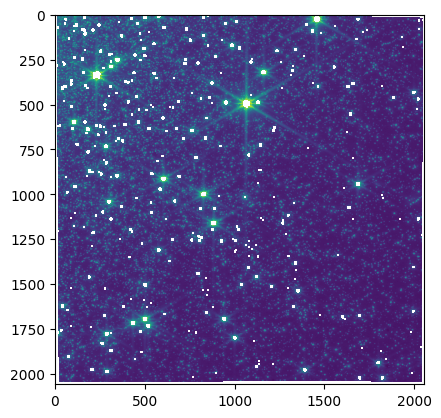

In [47]:
import matplotlib.pyplot as plt
plt.imshow(snr_dat)
plt.show()

### Multi-filter combine

In [16]:
import glob,os
import jwst
from astropy.io import fits
from jwst.associations import asn_from_list
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base
import shapely
%matplotlib inline
import matplotlib.pyplot as plt

In [17]:
f090_images = glob.glob('jwstred_temp_dolphot/jhat/*02101*fits')
f150_images = glob.glob('jwstred_temp_dolphot/jhat/*04101*fits')

In [18]:
#shapely polygons
pgons = []
for img in f150_images+f090_images:
    region = fits.getval(img, 'S_REGION', ext=1)
    coords = np.array(region.split('POLYGON ICRS  ')[1].split(' '), dtype = float)
    pgons.append(shapely.Polygon(coords.reshape(4, 2)))

In [19]:
#calculate net field
net_field = shapely.unary_union(pgons)

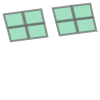

In [20]:
net_field

In [21]:
#collect edge points of the net field
points = []
for polygon in net_field.geoms:
    points.extend([list(i) for i in polygon.exterior.coords[:-1]])
points = np.array(points)

In [22]:
#find the bounds for the field
xmin, xmax, ymin, ymax = np.argmin(points[:, 0]), np.argmax(points[:, 0]), np.argmin(points[:, 1]), np.argmax(points[:, 1])

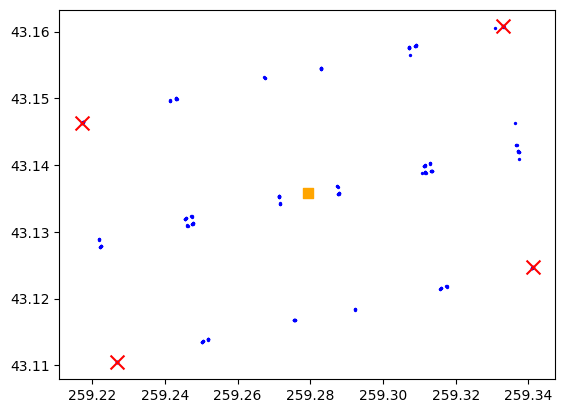

In [23]:
#plot the points and bounds
plt.scatter(points[:,0], points[:,1], marker = 'o', s = 2, color = 'blue')
plt.scatter(points[[xmin, xmax, ymin, ymax]][:, 0], points[[xmin, xmax, ymin, ymax]][:, 1], 
            marker = 'x', s = 100, color = 'red')
plt.scatter(net_field.centroid.x, net_field.centroid.y, marker = 's', color = 'orange', s = 50)
plt.show()

In [63]:
#create skycoord of the edge points
c=SkyCoord(points[[xmin, xmax, ymin, ymax]][:, 0], points[[xmin, xmax, ymin, ymax]][:, 1], unit = 'deg', frame = 'icrs')

In [81]:
#find the approximate bounding box dimensions of the field
#this calculation is done in (ra, dec) space so isn't the best way?
c[0].separation(c[2]).arcsec/0.031, c[0].separation(c[1]).arcsec/0.031

(4251.854867220238, 10811.275104119248)

In [75]:
#find bounding box dimesnions directly from the field
#kinda inaccurate since the field is rotated relative coordinate frame shapely assumes
(net_field.bounds[2] - net_field.bounds[0])*3600/0.031, (net_field.bounds[3] - net_field.bounds[1])*3600/0.031

(14407.468954837279, 5846.10979354902)

In [53]:
print(net_field.centroid)

POINT (259.2794680767732 43.135752140979484)


##### wcs check

In [10]:
from astropy import wcs
from gwcs import WCS as g_wcs

In [98]:
#read wcs for a single dither
hdu = fits.open('jwstred_temp_dolphot/jhat/jw01334001001_02101_00001_nrca1_jhat.fits')
sci_header = hdu['SCI'].header
w = wcs.WCS(sci_header)

In [12]:
#read wcs of the first mosaic and feed it to the second
#wcs for a long wavelength image can be "sliced" as wcs[::1/2, ::1/2] to make it short wavelength (i.e. double the resolution)
#(https://stackoverflow.com/questions/40475030/how-to-change-the-header-after-resizing-a-submap)
hdu = fits.open('jwstred_temp_dolphot/mosaic/f090w_i2d.fits')
sci_header = hdu['SCI'].header
w = wcs.WCS(sci_header)

In [11]:
from astropy.modeling import models
from astropy import coordinates as coord
from astropy import units as u
from gwcs import coordinate_frames as cf

In [361]:
#convert wcs to gwcs using code from reference
#(#https://www.zonca.dev/posts/2020-09-10-wcs-astropy.html)

#rotation from matrix needs to be accounted for, otherwise the gwcs doesnt match original
#(https://gwcs.readthedocs.io/en/latest/gwcs/fits_analog.html)

shift_by_crpix = models.Shift(-(sci_header['CRPIX1'] - 1)) & models.Shift(-(sci_header['CRPIX2'] - 1))
matrix = np.array([[sci_header['PC1_1'], sci_header['PC1_2']],
                   [sci_header['PC2_1'] , sci_header['PC2_2']]])
rotation = models.AffineTransformation2D(matrix , translation=[0, 0])

tan = models.Pix2Sky_TAN()
#pixelscale transform needed because of how jwst pipeline writes this to file
#otherwise unit equivalencies are sufficient
pixelscale = models.Scale(sci_header['CDELT1']) & models.Scale(sci_header['CDELT2'])
celestial_rotation =  models.RotateNative2Celestial(sci_header['CRVAL1'], sci_header['CRVAL2'], 180)

det2sky = shift_by_crpix | rotation | pixelscale | tan | celestial_rotation
det2sky.name = "linear_transform"

detector_frame = cf.Frame2D(name="detector", axes_names=("x", "y"),
                            unit=(u.pix, u.pix))
sky_frame = cf.CelestialFrame(reference_frame=coord.ICRS(), name='icrs',
                              unit=(u.deg, u.deg))

pipeline = [(detector_frame, det2sky),
            (sky_frame, None)
           ]
wcsobj = g_wcs(pipeline)
wcsobj.bounding_box = ((0, sci_header['NAXIS1']), (0, sci_header['NAXIS2']))
print(wcsobj)

  From      Transform    
-------- ----------------
detector linear_transform
    icrs             None


In [366]:
#write gwcs to asdf file
from asdf import AsdfFile
tree = {"wcs": wcsobj}
wcs_file = AsdfFile(tree)
wcs_file.write_to("jwstred_temp_dolphot/mosaic_gwcs.asdf")

In [367]:
#convert pixel to world to compare wcs and gwcs
pixcrd = np.array([[0, 0], [0, sci_header['NAXIS2']],[sci_header['NAXIS1'], sci_header['NAXIS2']], [sci_header['NAXIS1'],0]], dtype=np.float64)
world = w.wcs_pix2world(pixcrd, 0)

In [368]:
world, ((-world[0][0]+ world[-1][0]) * u.deg).to(u.arcsec), ((-world[0][1]+ world[1][1]) * u.deg).to(u.arcsec)

(array([[259.21642906,  43.14625082],
        [259.22571932,  43.11027841],
        [259.35106934,  43.12744826],
        [259.34185025,  43.16343077]]),
 <Quantity 451.51629228 arcsec>,
 <Quantity -129.50067104 arcsec>)

In [369]:
gwcs_crd = wcsobj(pixcrd[:,0], pixcrd[:,1], with_units=False)
gwcs_crd

(array([259.21642906, 259.22571932, 259.35106934, 259.34185025]),
 array([43.14625082, 43.11027841, 43.12744826, 43.16343077]))

In [371]:
wcsobj.forward_transform[3].factor

Parameter('factor', value=8.61111111111111e-06)

In [77]:
w.world_to_pixel(SkyCoord(259.22571932,  43.11027841, unit = 'deg', frame = 'icrs'))

(array(0.00027498), array(4251.00006794))

In [372]:
w.pixel_to_world(2000, 2000)

<SkyCoord (ICRS): (ra, dec) in deg
    (259.24399228, 43.13251438)>

In [373]:
wcsobj.pixel_to_world(2000, 2000)

<SkyCoord (ICRS): (ra, dec) in deg
    (259.24399228, 43.13251438)>

In [184]:
#change reference point to compare with dither wcs
w.wcs.crval = np.array([259.23102463946, 43.138970097072])
w.wcs.crpix = np.array([1024.5, 1024.5])

In [185]:
#pixel coordinates from dither wcs
w.world_to_pixel(sk_pts[0])

(array(2112.58835556), array(4159.72085648))

In [123]:
#skycoord of points
sk_pts = SkyCoord(points[:,0], points[:,1], frame = 'icrs', unit = 'deg')

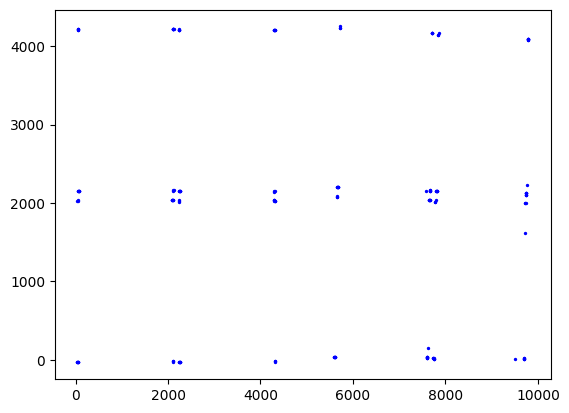

In [131]:
#convert from ra, dec to pixel coordinates
cvt = w.all_world2pix(points, 0)
plt.scatter(cvt[:,0], cvt[:,1], marker = 'o', s = 2, color = 'blue')
# plt.scatter(points[[xmin, xmax, ymin, ymax]][:, 0], points[[xmin, xmax, ymin, ymax]][:, 1], 
#             marker = 'x', s = 100, color = 'red')
# plt.scatter(net_field.centroid.x, net_field.centroid.y, marker = 's', color = 'orange', s = 50)
plt.show()

#### mosaic

In [374]:
#create mosaic
root_dir = '.'
filter_name = 'F150W'

In [375]:
input_images = f150_images
table = input_list(input_images)
tables = organize_reduction_tables(table, byvisit=False)
filter_name = table[0]['filter']

In [376]:
nircam_asn_file = f'jwstred_temp_dolphot/jhat/{filter_name}_c.json'
base_filenames = np.array([os.path.basename(r['image']) for r in table])
asn3 = asn_from_list.asn_from_list(base_filenames, 
    rule=DMS_Level3_Base, product_name=filter_name)

In [377]:
with open(nircam_asn_file, 'w') as outfile:
    name, serialized = asn3.dump(format='json')
    outfile.write(serialized)

In [378]:
print(asn3)

jwnoprogram-a3001_none_00009_asn with 1 products
Rule=DMS_Level3_Base
No constraints
Products:
	f150w with 32 members


In [380]:
from jwst.pipeline import calwebb_image3
image3 = calwebb_image3.Image3Pipeline()

outdir_level3 = os.path.join('jwstred_temp_dolphot/', 'mosaic')
if not os.path.exists(outdir_level3):
    os.makedirs(outdir_level3)

image3.output_dir = outdir_level3
image3.save_results = True
image3.tweakreg.skip = True
image3.skymatch.skip = True
image3.skymatch.match_down = False
image3.source_catalog.skip = False
image3.resample.pixfrac = 1.0
# image3.resample.output_shape = (sci_header['NAXIS1'], sci_header['NAXIS2'])
image3.resample.output_wcs = 'jwstred_temp_dolphot/mosaic_gwcs.asdf'
# image3.resample.pixfrac = 1.0
# image3.resample.pixel_scale = 0.031
# image3.resample.crval = (net_field.centroid.x , net_field.centroid.y)
# image3.resample.output_shape = (sci_header['NAXIS1'], sci_header['NAXIS2'])
image3.run(nircam_asn_file)

2025-01-01 01:29:04,643 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2025-01-01 01:29:04,645 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2025-01-01 01:29:04,648 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.
2025-01-01 01:29:04,650 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.
2025-01-01 01:29:04,651 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2025-01-01 01:29:04,652 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.
2025-01-01 01:29:04,653 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.
2025-01-01 01:29:04,972 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('jwstred_temp_dolphot/jhat/f150w_c.json',).
2025-01-01 01:29:04,978 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  outpu

#### psf matching

In [63]:
import webbpsf
from astropy.stats import sigma_clipped_stats as scs
from photutils.psf.matching import resize_psf, SplitCosineBellWindow, create_matching_kernel
from astropy.convolution import convolve, convolve_fft

In [90]:
nrc = webbpsf.NIRCam()
nrc.filter =  'F090W'
psf_f090 = nrc.calc_psf(oversample=4, fov_pixels=161) 

In [91]:
nrc.filter =  'F150W'
psf_f150 = nrc.calc_psf(oversample=4, fov_pixels=161) 

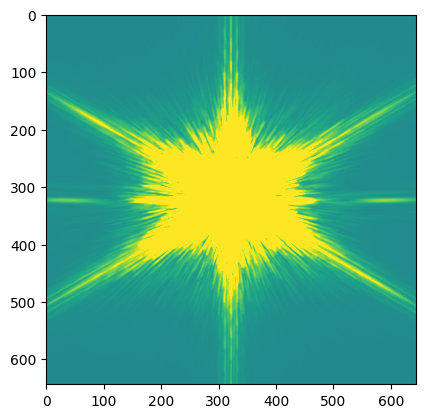

In [92]:
psf_dat = psf_f090[0].data
_, pmed, pstd = scs(psf_dat, sigma = 3.0)
plt.imshow(psf_dat, vmin = pmed - 3*pstd, vmax = pmed + 3*pstd)
plt.show()

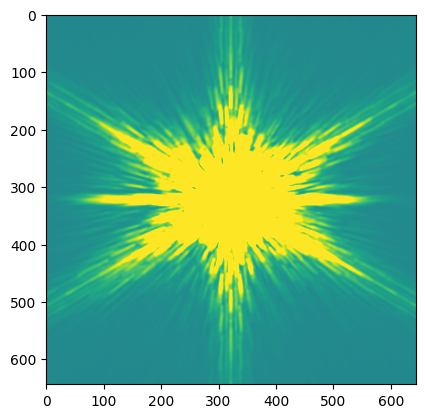

In [93]:
psf_dat = psf_f150[0].data
_, pmed, pstd = scs(psf_dat, sigma = 3.0)
plt.imshow(psf_dat, vmin = pmed - 3*pstd, vmax = pmed + 3*pstd)
plt.show()

In [96]:
# PSF_kernels = {}
# reference_filter = 'F200W'
reference_PSF = psf_f150[1].data
psfim = psf_f090[1].data
# i_reference = filters.index(reference_filter)
window = SplitCosineBellWindow(alpha=0.35, beta=0.3)
# for filt in filters[i_reference+1:]:
PSF_kernel = create_matching_kernel(reference_PSF, psfim, window=window)

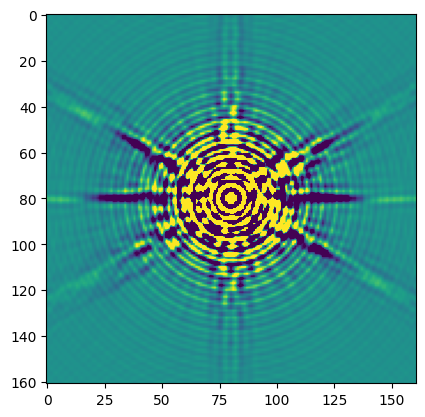

In [97]:
psf_dat = PSF_kernel
_, pmed, pstd = scs(psf_dat, sigma = 3.0)
plt.imshow(psf_dat, vmin = pmed - 3*pstd, vmax = pmed + 3*pstd)
plt.show()

In [99]:
refimage = fits.open('jwstred_temp_dolphot/mosaic/f090w_i2d.fits')
reference_image_data = refimage[1].data

In [100]:
convolved_image = convolve(reference_image_data, PSF_kernel, normalize_kernel=True)

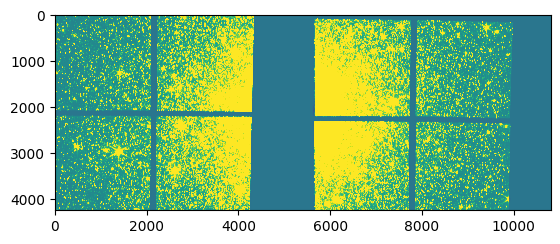

In [102]:
psf_dat = convolved_image
_, pmed, pstd = scs(psf_dat, sigma = 3.0)
plt.imshow(psf_dat, vmin = pmed - 3*pstd, vmax = pmed + 3*pstd)
plt.show()

In [104]:
refimage[1].data = convolved_image

In [107]:
refimage.writeto('jwstred_temp_dolphot/mosaic/F090W_convolved.fits')